In [14]:
#importy
import pandas as pd
import numpy as np
import warnings
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

np.random.seed(42) 

In [3]:
#Wczytanie zbioru danych
df = pd.read_csv("Exam_Score_Dataset.csv")
df

df.head(10)

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7
5,6,23,male,b.tech,3.48,65.4,yes,4.2,good,mixed,low,moderate,58.2
6,7,17,female,b.tech,1.35,69.0,yes,7.4,average,online videos,high,hard,53.7
7,8,22,male,b.sc,5.48,51.1,yes,8.2,poor,self-study,low,moderate,47.3
8,9,18,other,bca,2.89,92.0,yes,6.6,poor,self-study,low,easy,44.9
9,10,17,male,bba,6.77,44.8,yes,9.8,average,group study,high,moderate,77.7


In [4]:
#Sprawdzenie zbioru pod kątem wybrakowanych rekordów
df.isna().sum()

student_id          0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

In [5]:
#Spliting dataset into train and test
from sklearn.model_selection import train_test_split

df_full = pd.read_csv("Exam_Score_Dataset.csv")

for col in df_full.columns:
    if df_full[col].dtype == 'object':
        df_full[col] = df_full[col].fillna(df_full[col].mode()[0])
    else:
        df_full[col] = df_full[col].fillna(df_full[col].mean())

if 'student_id' in df_full.columns:
    df_full = df_full.drop(columns=['student_id'])

train_df = df_full.sample(frac=0.8, random_state=42).copy()
test_df = df_full.drop(train_df.index).copy()

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

TARGET = 'exam_score'
base_features = [col for col in train_df.columns if col != TARGET and train_df[col].dtype == 'object']
num_features = ['study_hours', 'class_attendance', 'sleep_hours']

train_df

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,21,other,bba,2.01,48.2,yes,4.9,poor,mixed,medium,easy,31.1
1,24,female,bba,6.56,45.9,no,4.4,good,coaching,high,hard,81.6
2,17,other,bba,4.27,41.0,yes,8.9,good,self-study,low,moderate,68.0
3,18,female,bba,7.28,91.7,yes,5.9,good,coaching,high,easy,100.0
4,22,female,bca,7.13,64.3,yes,9.5,good,online videos,low,moderate,84.8
...,...,...,...,...,...,...,...,...,...,...,...,...
15995,18,female,ba,2.53,83.5,yes,5.5,good,self-study,medium,moderate,64.4
15996,19,other,b.com,6.84,57.5,no,8.3,average,group study,low,moderate,65.6
15997,19,male,bba,3.57,77.0,no,7.7,average,online videos,low,moderate,47.2
15998,24,female,bba,7.13,45.6,yes,8.4,average,online videos,medium,easy,72.9


In [6]:
#Preprocess function
def preprocess(df):
    df_temp = df.copy()

    for col in num_features:
        if col in df_temp.columns:
            df_temp[f'log_{col}'] = np.log1p(df_temp[col])

    for col in num_features:
        if col in df_temp.columns:
            df_temp[f'{col}_sq'] = df_temp[col] ** 2
            
    df_temp['feature_formula'] = (
        5.9051154511950499 * df_temp['study_hours'] + 
        0.34540967058057986 * df_temp['class_attendance'] + 
        1.423461171860262 * df_temp['sleep_hours'] + 4.7819
    )

    for col in base_features:
        df_temp[col] = df_temp[col].astype(str)

    log_cols = [f'log_{col}' for col in num_features]
    sq_cols = [f'{col}_sq' for col in num_features]
    
    return df_temp[base_features + num_features + log_cols + sq_cols + ['feature_formula']]


In [7]:
#Data preprocessing
y = train_df[TARGET]
X_raw = preprocess(train_df.drop(columns=[TARGET]))
X_test_raw = preprocess(test_df.drop(columns=[TARGET]))

full_data = pd.concat([X_raw, X_test_raw], axis=0)

for col in base_features:
    full_data[col] = full_data[col].astype('category')

engineered_cols = ['feature_formula'] + \
                  [f'log_{col}' for col in num_features] + \
                  [f'{col}_sq' for col in num_features] + num_features

for col in engineered_cols:
    if col in full_data.columns:
        full_data[col] = full_data[col].astype(float)

X = full_data.iloc[:len(train_df)].copy()
X_test = full_data.iloc[len(train_df):].copy()
X_test

,gender,course,internet_access,sleep_quality,study_method,facility_rating,exam_difficulty,study_hours,class_attendance,sleep_hours,log_study_hours,log_class_attendance,log_sleep_hours,study_hours_sq,class_attendance_sq,sleep_hours_sq,feature_formula
0,male,b.sc,yes,poor,coaching,high,moderate,7.88,76.8,8.5,2.183802,4.354141,2.251292,62.0944,5898.24,72.25,89.941092
1,male,bba,yes,average,group study,high,moderate,6.77,44.8,9.8,2.050270,3.824284,2.379546,45.8329,2007.04,96.04,74.183804
2,male,b.com,no,poor,online videos,medium,easy,3.77,96.6,4.1,1.562346,4.580877,1.629241,14.2129,9331.56,16.81,66.246950
3,female,bba,yes,poor,online videos,medium,moderate,0.81,66.0,7.1,0.593327,4.204693,2.091864,0.6561,4356.00,50.41,42.468656
4,male,b.sc,yes,average,self-study,medium,moderate,1.97,91.9,8.3,1.088562,4.531524,2.230014,3.8809,8445.61,68.89,59.972854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,other,ba,yes,poor,coaching,medium,hard,5.93,63.2,4.4,1.935860,4.162003,1.686399,35.1649,3994.24,19.36,67.892355
3996,male,bca,yes,good,self-study,high,easy,4.25,93.9,9.8,1.658228,4.552824,2.379546,18.0625,8817.21,96.04,76.262528
3997,male,b.com,yes,good,online videos,high,hard,5.74,81.4,7.5,1.908060,4.411585,2.140066,32.9476,6625.96,56.25,77.469569
3998,other,diploma,yes,poor,group study,low,easy,7.88,68.2,4.6,2.183802,4.237001,1.722767,62.0944,4651.24,21.16,81.419071


In [19]:
# Model Training
xgb_params = {
    'n_estimators': 10000,
    'learning_rate': 0.007,
    'max_depth': 7,
    'subsample': 0.8,
    'num_parallel_tree': 2,
    'reg_lambda': 3,
    'colsample_bytree': 0.7, 
    'tree_method': 'hist',
    'random_state': 42,
    'early_stopping_rounds': 100,
    'eval_metric': 'rmse',
    'enable_categorical': True,
    'n_jobs': -1
}

test_predictions = []
oof_predictions = np.zeros(len(X))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

importances_list = []

for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f"\n--- Fold {fold+1} ---")

    X_train_fold, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val = y.iloc[train_index], y.iloc[val_index] 

    model = xgb.XGBRegressor(**xgb_params) 
    
    model.fit(
        X_train_fold, 
        y_train_fold, 
        eval_set=[(X_val, y_val)], 
        verbose=500
    )  

    fold_importance = pd.DataFrame()
    fold_importance["feature"] = X.columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold + 1
    importances_list.append(fold_importance)
    
    val_preds = model.predict(X_val)
    oof_predictions[val_index] = val_preds
    
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    r2 = r2_score(y_val, val_preds)
    
    print(f"Fold {fold+1} RMSE: {rmse:.4f}") 
    print(f"Fold {fold+1} R2:   {r2:.4f}")
    
    test_preds = model.predict(X_test)
    test_predictions.append(test_preds)


--- Fold 1 ---
[0]	validation_0-rmse:18.89127
[500]	validation_0-rmse:9.94444
[882]	validation_0-rmse:9.88916
Fold 1 RMSE: 9.8881
Fold 1 R2:   0.7275

--- Fold 2 ---
[0]	validation_0-rmse:18.78090
[500]	validation_0-rmse:10.01231
[704]	validation_0-rmse:10.00739
Fold 2 RMSE: 10.0020
Fold 2 R2:   0.7180

--- Fold 3 ---
[0]	validation_0-rmse:18.80322
[500]	validation_0-rmse:9.82373
[809]	validation_0-rmse:9.78834
Fold 3 RMSE: 9.7867
Fold 3 R2:   0.7303

--- Fold 4 ---
[0]	validation_0-rmse:18.80171
[500]	validation_0-rmse:10.04186
[833]	validation_0-rmse:10.00360
Fold 4 RMSE: 10.0021
Fold 4 R2:   0.7185

--- Fold 5 ---
[0]	validation_0-rmse:18.70435
[500]	validation_0-rmse:9.85630
[865]	validation_0-rmse:9.82715
Fold 5 RMSE: 9.8231
Fold 5 R2:   0.7258


In [9]:
#Results
oof_rmse = np.sqrt(mean_squared_error(y, oof_predictions))
oof_r2 = r2_score(y, oof_predictions)

print("-----------------------")
print(f"OVERALL RMSE: {oof_rmse:.4f}")
print(f"OVERALL R2:   {oof_r2:.4f}")

avg_test_preds = np.mean(test_predictions, axis=0)
print(f"\nPrzykładowe predykcje na zbiorze testowym: {avg_test_preds[:5]}")

-----------------------
OVERALL RMSE: 9.9008
OVERALL R2:   0.7241

Przykładowe predykcje na zbiorze testowym: [89.75984  76.98894  59.52249  36.25553  56.430653]


Text(0, 0.5, 'Przewidywane (y_pred)')

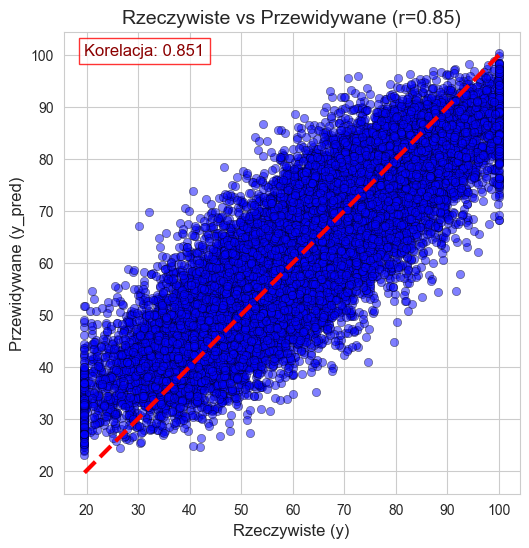

In [17]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)

corr = np.corrcoef(y, oof_predictions)[0, 1]

sns.scatterplot(x=y, y=oof_predictions, alpha=0.5, color='blue', edgecolor='k')

plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=3, linestyle='--')

plt.text(x=y.min(), 
         y=y.max(), 
         s=f'Korelacja: {corr:.3f}', 
         fontsize=12, 
         color='darkred',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

plt.title(f'Rzeczywiste vs Przewidywane (r={corr:.2f})', fontsize=14)
plt.xlabel('Rzeczywiste (y)', fontsize=12)
plt.ylabel('Przewidywane (y_pred)', fontsize=12)

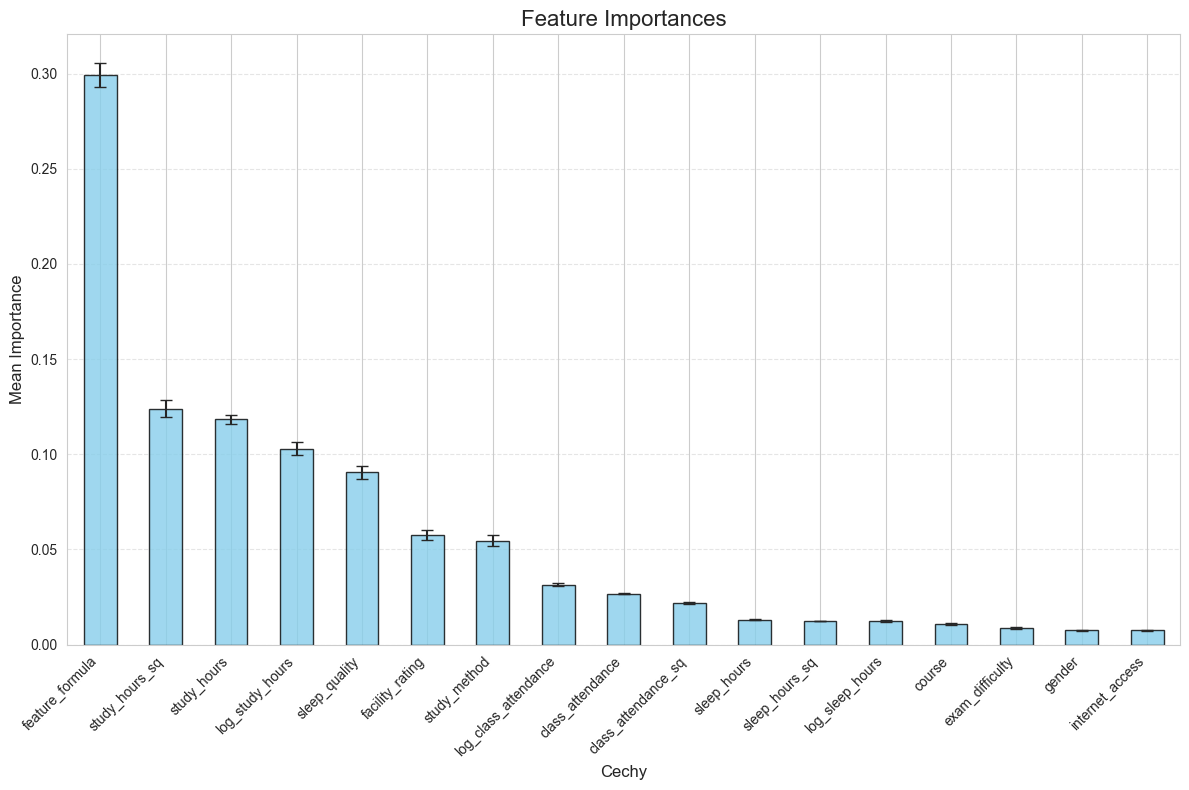

In [21]:
all_importances = pd.concat(importances_list, axis=0)

feature_stats = all_importances.groupby("feature").agg(
    mean_importance=("importance", "mean"),
    std_importance=("importance", "std")
).sort_values("mean_importance", ascending=False)

top_features = feature_stats.head(20)

fig, ax = plt.subplots(figsize=(12, 8))

top_features["mean_importance"].plot.bar(
    yerr=top_features["std_importance"], 
    ax=ax, 
    capsize=4,
    color='skyblue', 
    edgecolor='black',
    alpha=0.8
)

ax.set_title("Feature Importances", fontsize=16)
ax.set_ylabel("Mean Importance", fontsize=12)
ax.set_xlabel("Cechy", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

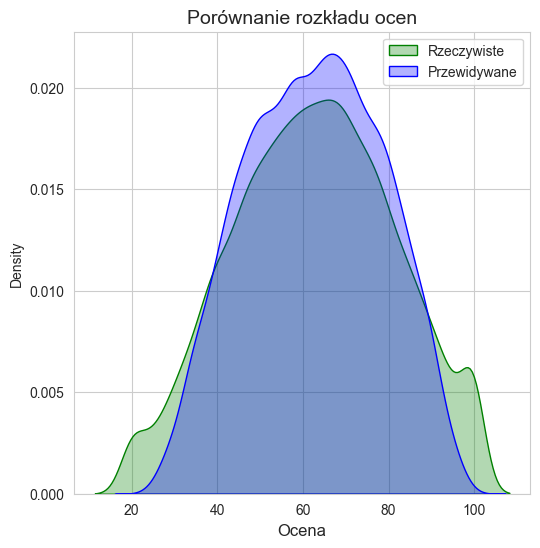

In [24]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 2)
sns.kdeplot(y, label='Rzeczywiste', fill=True, color='green', alpha=0.3)
sns.kdeplot(oof_predictions, label='Przewidywane', fill=True, color='blue', alpha=0.3)
plt.title('Porównanie rozkładu ocen', fontsize=14)
plt.xlabel('Ocena', fontsize=12)
plt.legend()